# TMCA Water Usage

In [9]:
# imports
import pandas as pd
import re
import plotly.express as px
import pingouin as pg

# display options
pd.options.display.max_columns = 100

# number of residents per unit mapping taken from https://www.tuckermathews.com/p/Residents
n_resident_dict = {
    'unit_1': 1,
    'unit_2': 2,
    'unit_3': 1,
    'unit_4': 1,
    'unit_5': 1,
    'unit_6': 1,
    'unit_7': 1,
    'unit_8': 2,
    'unit_9': 1,
    'unit_1r': 1,
    'unit_2r': 1,
    'unit_3r': 1,
    'unit_4r': 1
}

# convert to dataframe for joining purposes
n_resident_lkup = pd.DataFrame(
    n_resident_dict.items(), 
    columns=["unit", "n_residents"]
)

# read in trustee data, reshape, and rename columns
df = pd.read_excel(
    "/Users/grahamthomson/Downloads/TMCA Water Meter Readings .xlsx", 
    engine="openpyxl"
).transpose().reset_index()

units = ['unit_1', 'unit_2', 'unit_3',
     'unit_4', 'unit_5', 'unit_6',
     'unit_7', 'unit_8', 'unit_9',
     'unit_1r', 'unit_2r', 'unit_3r',
     'unit_4r']

df.columns = ["date"] + units

# filter out any row that isnt just a date and reading per unit
df = df[df["date"].apply(lambda x: True if re.match("\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", str(x)) else False)]

for c in df.columns:
    # create lagged readings
    df[f"{c}_previous_reading"] = df[f"{c}"].shift(1)
    
    # calculate reading difference and date diff
    if c == "date":
        df["days_between_readings"] = (df["date"] - df[f"{c}_previous_reading"])
        df["days_between_readings"] = df["days_between_readings"].apply(lambda x: x.days)
    else:
        df[f"{c}_difference"] = df[f"{c}"] - df[f"{c}_previous_reading"]
        df[f"{c}_avg_daily_difference"] = df[f"{c}_difference"] / df["days_between_readings"]

# sort columns
df = df[sorted(df.columns)]

## Total Usage by Unit

In [10]:
total_usage = pd.DataFrame([[u, df[u].max() - df[u].min(), n_resident_dict[u]] for u in units], columns=["unit", "total_usage", "n_residents"])
total_usage["n_residents_percent"] = total_usage["n_residents"] / total_usage["n_residents"].sum()
total_usage["total_usage_percent"] = total_usage["total_usage"] / total_usage["total_usage"].sum()
total_usage["usage_index"] = total_usage["total_usage_percent"] / total_usage["n_residents_percent"]
total_usage = total_usage.sort_values("usage_index", ascending=False)

total_usage.style\
.background_gradient(subset=["total_usage_percent", "n_residents_percent", "usage_index"])\
.format("{:.2%}", subset=["total_usage_percent", "n_residents_percent"])\
.hide_index()

unit,total_usage,n_residents,n_residents_percent,total_usage_percent,usage_index
unit_1,7131,1,6.67%,10.54%,1.581387
unit_2r,7023,1,6.67%,10.38%,1.557436
unit_8,12994,2,13.33%,19.21%,1.440789
unit_7,6310,1,6.67%,9.33%,1.399320
unit_6,5360,1,6.67%,7.92%,1.188646
unit_5,4712,1,6.67%,6.97%,1.044944
unit_3r,4433,1,6.67%,6.55%,0.983072
unit_4r,4208,1,6.67%,6.22%,0.933176
unit_3,3356,1,6.67%,4.96%,0.744234
unit_4,3261,1,6.67%,4.82%,0.723167


## Box Plots / Normalization

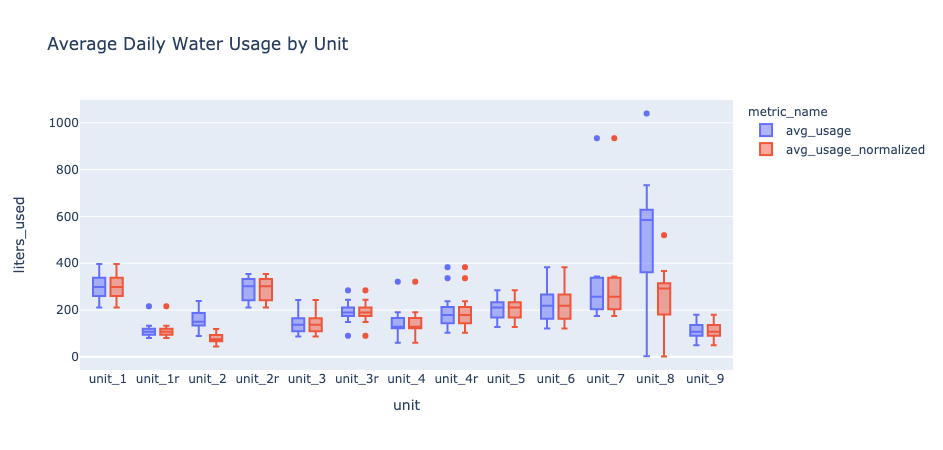

In [11]:
# daily average usage
dau = df[[c for c in df.columns if c.endswith("_avg_daily_difference")]].dropna().melt()
dau.columns = ["unit", "avg_usage"]
dau["unit"] = dau["unit"].apply(lambda x: x.replace("_avg_daily_difference", ""))

dau_normalized = dau.merge(n_resident_lkup, on="unit")
dau_normalized["avg_usage_normalized"] = dau_normalized["avg_usage"] / dau_normalized["n_residents"]
dau_normalized = dau_normalized.melt(
    id_vars="unit", 
    value_vars=["avg_usage", "avg_usage_normalized"], 
    var_name="metric_name",
    value_name="liters_used"
)
px.box(
    data_frame=dau_normalized, 
    x="unit", 
    y="liters_used", 
    color="metric_name", 
    title="Average Daily Water Usage by Unit"
)

## Statistical Tests

In [4]:
pg.ttest(
    x=dau_normalized.query("(unit == 'unit_8') & (metric_name == 'avg_usage_normalized')")["liters_used"].astype(float),
    y=dau_normalized.query("(unit == 'unit_2') & (metric_name == 'avg_usage_normalized')")["liters_used"].astype(float)
)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.560012,22,two-sided,0.000154,"[99.82, 266.36]",1.861617,141.665,0.991651


In [5]:
pg.ttest(
    x=dau_normalized.query("(unit == 'unit_8') & (metric_name == 'avg_usage_normalized')")["liters_used"].astype(float),
    y=dau_normalized.query("(unit == 'unit_7') & (metric_name == 'avg_usage_normalized')")["liters_used"].astype(float)
)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.725703,22,two-sided,0.47567,"[-199.09, 95.87]",0.296267,0.452,0.106819
